In [2]:
import psycopg2
from langchain_ollama.embeddings import OllamaEmbeddings
from langchain_ollama import OllamaLLM
from langchain_chroma import Chroma
from langchain_core.documents import Document
import chromadb

In [3]:
# Étape 1 : Connexion PostgreSQL
conn = psycopg2.connect(
    dbname="faqdb",
    user="faquser",
    password="faqpass",
    host="localhost",
    port="5432"
)

cur = conn.cursor()
cur.execute("SELECT question, procede FROM FAQ")
rows = cur.fetchall()

# Étape 2 : Conversion en documents LangChain
documents = [Document(page_content=row[1], metadata={"question": row[0]}) for row in rows]

documents


[Document(metadata={'question': 'Comment réinitialiser mon mot de passe ?'}, page_content="Accédez à la page de connexion de la plateforme. Cliquez sur 'Mot de passe oublié'. Entrez votre adresse e-mail associée à votre compte. Vous recevrez un lien de réinitialisation par e-mail. Cliquez dessus et définissez un nouveau mot de passe sécurisé."),
 Document(metadata={'question': "Je n'arrive pas à me connecter à mon compte."}, page_content="Vérifiez d'abord que vos identifiants sont corrects. Si vous avez oublié votre mot de passe, utilisez la fonction 'Mot de passe oublié'. Si le problème persiste, contactez le support technique en précisant l'erreur affichée."),
 Document(metadata={'question': 'Comment signaler un bug sur la plateforme ?'}, page_content="Cliquez sur le bouton 'Signaler un problème' en bas à gauche. Décrivez le bug rencontré avec les étapes pour le reproduire. Si possible, joignez une capture d’écran. Le support technique vous répondra rapidement."),
 Document(metadata=

In [4]:
# Étape 3 : Initialisation des embeddings avec Ollama
embeddings = OllamaEmbeddings(model="nomic-embed-text")  # ou autre modèle compatible

# Étape 4 : Sauvegarde dans Chroma (persistant)
db = Chroma.from_documents(
    documents=documents,
    embedding=embeddings,
    persist_directory="./chroma_faq"
)

# Sauvegarde explicite si besoin
# db.persist()

print(f"{len(rows)} documents indexés avec succès.")

30 documents indexés avec succès.


In [7]:
query = "Je n'arrive pas à me connecter à mon compte"
# results = db.similarity_search(query, k=4)

# for i, doc in enumerate(results, 1):
#     print(f"Résultat {i} :\n{doc.metadata['question']}\n➡ {doc.page_content}\n")


In [4]:
db = None
embeddings = OllamaEmbeddings(model="nomic-embed-text")
db= Chroma(
    persist_directory="./chroma_faq", 
    embedding_function=embeddings
)

In [11]:
db=None

In [5]:
retriever = db.as_retriever()

In [8]:
docs= retriever.invoke(query)

In [9]:
len(docs)

4

In [10]:
docs

[Document(id='03e8d92e-2720-417c-bcf0-3ff0cabdc090', metadata={'question': 'Comment modifier mes informations personnelles ?'}, page_content="Connectez-vous à votre compte. Allez dans la section 'Profil' ou 'Paramètres'. Cliquez sur 'Modifier les informations'. Mettez à jour vos données (nom, prénom, téléphone, etc.), puis cliquez sur 'Enregistrer'."),
 Document(id='78a08d7c-45fc-42ef-a52e-c657df510e92', metadata={'question': 'Je ne peux pas envoyer de messages.'}, page_content='Vérifiez si vous êtes bien connecté et que votre compte est actif. Assurez-vous que le destinataire vous autorise à le contacter. Essayez depuis un autre navigateur ou appareil pour exclure un bug local.'),
 Document(id='b2d7c151-02c5-4e75-9ad7-a84ba5a33195', metadata={'question': 'Comment supprimer mon compte ?'}, page_content="Connectez-vous, allez dans 'Paramètres' > 'Confidentialité'. Cliquez sur 'Supprimer mon compte'. Confirmez votre mot de passe et validez. Vos données seront supprimées dans les 30 jours

In [13]:
retriever = db.as_retriever(search_kwargs={"k": 4})

In [14]:
retriever.search_type

'similarity'

# Make a chain

In [15]:
from langchain.chains import RetrievalQA

In [16]:
llm=OllamaLLM(model="mistral", temperature=0.1)

In [17]:
llm

OllamaLLM(model='mistral', temperature=0.1)

In [18]:
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=retriever,
    return_source_documents=True
)

In [20]:
def process_llm_response(llm_response):
    print(llm_response['result'])
    # print('\n\nSources:')
    # for source in llm_response["source_documents"]:
    #     print(source.metadata['question'])

In [21]:
llm_response = qa_chain.invoke(query)

llm_response

{'query': "Je n'arrive pas à me connecter à mon compte",
 'result': '1. Ensure that you are entering the correct login credentials (email and password).\n2. Check if your account is active. If it\'s not, you may need to activate it or reset your password.\n3. Try logging in from a different browser or device to exclude a local bug.\n4. Make sure that there are no typos or errors in the URL of the website you are trying to access.\n5. If you still can\'t log in, try resetting your password by clicking on "Forgot Password" or "Reset Password" link on the login page.\n6. If none of these steps work, contact the customer support team for assistance.',
 'source_documents': [Document(id='03e8d92e-2720-417c-bcf0-3ff0cabdc090', metadata={'question': 'Comment modifier mes informations personnelles ?'}, page_content="Connectez-vous à votre compte. Allez dans la section 'Profil' ou 'Paramètres'. Cliquez sur 'Modifier les informations'. Mettez à jour vos données (nom, prénom, téléphone, etc.), pui

In [22]:
process_llm_response(llm_response)

1. Ensure that you are entering the correct login credentials (email and password).
2. Check if your account is active. If it's not, you may need to activate it or reset your password.
3. Try logging in from a different browser or device to exclude a local bug.
4. Make sure that there are no typos or errors in the URL of the website you are trying to access.
5. If you still can't log in, try resetting your password by clicking on "Forgot Password" or "Reset Password" link on the login page.
6. If none of these steps work, contact the customer support team for assistance.


## Essai stream

In [3]:
from langchain_ollama import OllamaLLM
from langchain_chroma import Chroma
from langchain.chains import RetrievalQA
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

In [6]:
embeddings = OllamaEmbeddings(model="nomic-embed-text")

In [11]:
vectorstore = Chroma(
    persist_directory="./chroma_faq",
    embedding_function=embeddings  # Embedding déjà présent
)

In [13]:
retriever = vectorstore.as_retriever(search_kwargs={"k": 4})

In [40]:
llm = OllamaLLM(
    model="mistral",
    temperature=0.2,
    streaming=True,
    callbacks=[StreamingStdOutCallbackHandler()]  # Affiche dans la console
)

In [41]:
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=retriever,
    return_source_documents=True
)

In [43]:
# query = "Comment puis-je signaler un bug sur la plateforme ?"
# import base64
# def to_base64(image_path: str) -> str:
#         with open(image_path, "rb") as img_file:
#             return base64.b64encode(img_file.read()).decode("utf-8")
        
# image= to_base64("faq.jpg")
# image
response = qa_chain.invoke("Je veux créer un compte je fais comment ?")

# print("\nRéponse complète :")
# print(response["result"])

 To create an account, you can follow these steps:

1. Go to the login page.
2. Click on 'Sign Up' or 'Create Account'.
3. Fill in the required fields such as your email address, password, and any other information asked for.
4. Confirm that you have read and agreed to the platform's terms of service and privacy policy.
5. Click on 'Submit' or 'Create Account' to complete the registration process.
6. You will then receive an email to verify your account. Follow the instructions in the email to activate your account.

In [78]:
print("\n📚 Sources :")
for doc in response["source_documents"]:
    print(f"- {doc.metadata['question']}")


📚 Sources :
- Comment modifier mes informations personnelles ?


In [86]:
process_llm_response(response)

 If you can't log in to your account, it might be due to several reasons such as incorrect login credentials or a problem with the website. Here are some troubleshooting steps you could try:

1. Check that you have entered the correct email address and password.
2. Make sure that CAPS LOCK is off when entering your password.
3. If you recently changed your password, make sure you're using the new one.
4. Try resetting your password if you can't remember it or think it might have been changed.
5. Clear your browser cache and cookies, as they may be causing issues with the login process.
6. If you continue to experience problems, contact the website's support team for assistance.


Sources:
Comment modifier mes informations personnelles ?


## Encore test

In [10]:
import base64
def to_base64(image_path: str) -> str:
        with open(image_path, "rb") as img_file:
            return base64.b64encode(img_file.read()).decode("utf-8")

In [11]:
image= to_base64("faq.jpg")
image

'/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAMCAgICAgMCAgIDAwMDBAYEBAQEBAgGBgUGCQgKCgkICQkKDA8MCgsOCwkJDRENDg8QEBEQCgwSExIQEw8QEBD/2wBDAQMDAwQDBAgEBAgQCwkLEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBD/wAARCAFgA1wDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD85rvXdZuL6SCDVNQt5mwGlaZjuHpjP9aij17Wpd32fVb+DaxD7pmO4+vWqmpDfcSxXJ8q3yPn67qibEqol6XVlI+zqpxvXt+B9a5rXPq6kv3kr9fl6f8AD9TQXWr5bT7WdXvhb7SrW5mYKSegHP1qS41rUVgS6l17UJVkbEU

In [39]:
from langchain_ollama import OllamaLLM
from langchain_chroma import Chroma

# Fonction qui retourne un vrai flux de tokens générés
def stream_mistral_response(query: str):
    # Charger Chroma
    vectorstore = Chroma(
        persist_directory="./chroma_faq",
        embedding_function=embeddings
    )
    retriever = vectorstore.as_retriever(search_kwargs={"k": 3})

    # Récupérer les documents les plus pertinents
    docs = retriever.invoke(query)
    context = "\n\n".join(doc.page_content for doc in docs)

    # Construire prompt
    prompt = f"""Tu es un assistant intelligent. Voici des documents pouvant t’aider à répondre.
Documents :
{context}

Question :
{query}

Réponse (sois clair, concis et précis) :
"""

    # Initialiser Ollama avec streaming natif
    llm = OllamaLLM(model="mistral", temperature=0.2)

    # Retourner un vrai générateur depuis Ollama
    for chunk in llm.stream(prompt):
        yield chunk


for token in stream_mistral_response(query):
    print(token, end="", flush=True)


1. Essayez de vous connecter en utilisant un autre navigateur ou appareil pour exclure un bug local.
2. Assurez-vous que votre adresse e-mail et mot de passe sont corrects.
3. Si le problème persiste, essayez de réinitialiser votre mot de passe en cliquant sur 'Réinitialiser mon mot de passe' dans la page de connexion.
4. Si vous n'avez toujours pas pu vous connecter, contactez le support technique pour plus d'aide.

## Test avec Image

In [27]:
import base64
import requests

def ask_ollama_with_image(prompt: str, image_path: str=None):
    
    if image_path:
        with open(image_path, "rb") as f:
            image_base64 = base64.b64encode(f.read()).decode("utf-8")
    else:
        image_base64 = None
    payload = {
        "model": "mistral",
        "prompt": prompt,
        "images": [image_base64],
        "stream": False
    }

    response = requests.post("http://localhost:11434/api/generate", json=payload)
    response.raise_for_status()
    return response.json()["response"]


In [34]:
def rag_llava_response(user_question: str, image_path: str = None):
    # Recherche vectorielle
    vectorstore = Chroma(persist_directory="./chroma_faq", embedding_function=embeddings)
    retriever = vectorstore.as_retriever(search_kwargs={"k": 4})
    docs = retriever.invoke(user_question)
    context = "\n\n".join(doc.page_content for doc in docs)

    # Construction du prompt
    prompt = f"""
    Tu es un assistant intelligent. Voici des documents extraits d'une base de connaissance :
    {context}
    Tire tes réponses de ces documents. Une proposition par document

    Voici sa question :
    {user_question}

    Réponds de manière claire et détaillée.
    """

    return ask_ollama_with_image(prompt, image_path)


In [35]:
result = rag_llava_response(query)

# "Pourquoi mon interface affiche cette erreur ?",
    # image_path="faq.jpg"

print(result)


1. Essayez d'utiliser un autre navigateur ou appareil pour vous connecter à votre compte, car il est possible qu'il y ait un problème local.

2. Si cela ne fonctionne toujours pas, assurez-vous que vous avez entré les informations de connexion correctes (nom d'utilisateur et mot de passe).

3. Vérifiez si votre compte est actif, car il peut être suspendu ou bloqué en cas de violation des conditions générales d'utilisation.

4. Essayez de vous réinitialiser le mot de passe si vous n'en avez plus accès ou si vous pensez que celui-ci a été compromis.

5. Si tous les autres solutions ne fonctionnent toujours pas, n'hésitez pas à contacter le support technique pour obtenir de l'aide supplémentaire.


In [30]:
docs = retriever.invoke(query)
docs

[Document(id='03e8d92e-2720-417c-bcf0-3ff0cabdc090', metadata={'question': 'Comment modifier mes informations personnelles ?'}, page_content="Connectez-vous à votre compte. Allez dans la section 'Profil' ou 'Paramètres'. Cliquez sur 'Modifier les informations'. Mettez à jour vos données (nom, prénom, téléphone, etc.), puis cliquez sur 'Enregistrer'."),
 Document(id='78a08d7c-45fc-42ef-a52e-c657df510e92', metadata={'question': 'Je ne peux pas envoyer de messages.'}, page_content='Vérifiez si vous êtes bien connecté et que votre compte est actif. Assurez-vous que le destinataire vous autorise à le contacter. Essayez depuis un autre navigateur ou appareil pour exclure un bug local.'),
 Document(id='b2d7c151-02c5-4e75-9ad7-a84ba5a33195', metadata={'question': 'Comment supprimer mon compte ?'}, page_content="Connectez-vous, allez dans 'Paramètres' > 'Confidentialité'. Cliquez sur 'Supprimer mon compte'. Confirmez votre mot de passe et validez. Vos données seront supprimées dans les 30 jours

## ConversationalRetrievalChain

In [12]:
from langchain.chains import ConversationalRetrievalChain
from langchain_ollama import OllamaLLM
from langchain_chroma import Chroma
from langchain.memory import ConversationBufferMemory

# Vectorstore
vectorstore = Chroma(
    persist_directory="./chroma_faq",
    embedding_function=embeddings
)

retriever = vectorstore.as_retriever(search_kwargs={"k": 3})

# Mémoire de conversation
memory = ConversationBufferMemory(
    memory_key="chat_history", return_messages=True
)

# Modèle LLM
llm = OllamaLLM(model="mistral", temperature=0.2)

# Chaîne conversationnelle
qa_chain = ConversationalRetrievalChain.from_llm(
    llm=llm,
    retriever=retriever,
    memory=memory,
    return_source_documents=False
)

# Test de conversation
chat_1 = qa_chain.invoke({"question": "Comment changer mon mot de passe ?"})
chat_2 = qa_chain.invoke({"question": "Et si j'ai perdu mon email ?"})
chat_3 = qa_chain.invoke({"question": "Si tu te rappelle de mon ancienne question alors quelle etait mon ancienne question ?"})# mémoire utilisée ici

print(chat_2["answer"])


 If you have lost the email address associated with your account, the process to reset your password may not be straightforward. Since the password reset link is sent via email, you might need to contact the platform support team for assistance. You can use the integrated contact form on the platform or send an email to support@votreplateforme.com, providing as many details as possible about your problem to facilitate a quick resolution. They may be able to help you regain access to your account by verifying your identity in some other way. However, the exact process might depend on the specific policies and procedures of the platform.


In [13]:
print(chat_3["answer"])

 Your previous question was not provided in the context you've given. The text provided appears to be instructions for using a platform or website, but it doesn't contain a question.


In [17]:
from langchain_ollama import OllamaLLM
from langchain_chroma import Chroma

# Contexte de mémoire manuelle (liste de tuples question, réponse)
chat_history = []

# Fonction génératrice avec mémoire
def stream_rag_with_memory(user_question: str):
    # 1. Recherche vectorielle
    vectorstore = Chroma(
        persist_directory="./chroma_faq",
        embedding_function=embeddings
    )
    retriever = vectorstore.as_retriever(search_kwargs={"k": 3})
    docs = retriever.invoke(user_question)
    context = "\n\n".join(doc.page_content for doc in docs)

    # 2. Historique formaté
    history_text = ""
    for q, a in chat_history:
        history_text += f"Utilisateur : {q}\nAssistant : {a}\n"

    # 3. Prompt complet
    prompt = f"""
Tu es un assistant intelligent.
Voici l'historique de la conversation :
{history_text}

Voici des documents qui pourraient t’aider :
{context}

Nouvelle question : {user_question}
Réponds de façon claire, utile et précise.
"""

    # 4. LLM avec streaming
    llm = OllamaLLM(model="mistral", temperature=0.2)

    full_answer = ""
    for chunk in llm.stream(prompt):
        token = chunk
        full_answer += token
        yield token

    # 5. Sauvegarder en mémoire (à la fin)
    chat_history.append((user_question, full_answer))


In [18]:
for token in stream_rag_with_memory("Comment signaler un bug ?"):
    print(token, end="", flush=True)

# Puis
for token in stream_rag_with_memory("Et si je ne peux plus accéder à mon compte ?"):
    print(token, end="", flush=True)


 Pour signaler un problème sur notre plateforme, vous pouvez suivre les étapes ci-dessous :

1. Cliquez sur le bouton 'Signaler un problème' en bas à gauche de l'écran. Ce bouton est généralement situé dans la barre latérale ou dans le menu contextuel.
2. Une fenêtre s'ouvrira où vous pourrez décrire le bug rencontré avec les étapes pour le reproduire. Veuillez être précis et fournir toutes les informations nécessaires pour que notre équipe puisse résoudre le problème rapidement.
3. Si possible, joignez une capture d’écran du bug pour aider à mieux comprendre la situation.
4. Appuyez sur 'Envoyer' ou 'Signaler'. Votre message sera alors envoyé à notre équipe de support technique qui vous répondra rapidement.

Si le bouton 'Signaler un problème' n'apparaît pas, vous pouvez également nous contacter par courrier électronique en nous fournissant les informations nécessaires pour reproduire le bug. Nous vous répondrons dans les plus brefs délais possible. Si vous ne pouvez plus accéder à vo

# LangGraph.py

In [19]:
!pip install langgraph


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [22]:
import requests
import json
from langgraph.graph import StateGraph, END
from langchain_chroma import Chroma
from langchain.chains import ConversationalRetrievalChain
from langchain.memory import ConversationBufferMemory
from langchain_ollama import OllamaLLM

# ----------- ÉTAT PARTAGÉ DU GRAPH -----------
class State(dict):
    question: str
    classification: dict | None
    response: str | None
    chat_history: list | None  # utile pour la mémoire de la chaîne

# ----------- NŒUD 1 : Classification (si pas encore faite) -----------
def check_classification(state: State) -> State:
    if state.get("classification"):
        return state  # déjà fait

    prompt = f"""
Tu es un système d'assistance interne.
L'utilisateur a posé la question suivante :

"{state['question']}"

Déduis uniquement :
- le **type** du problème : BUG, INCIDENT, QUESTION, SUGGESTION
- la **sévérité** : FAIBLE, MOYENNE, CRITIQUE

Réponds uniquement en JSON :
{{
  "type": "...",
  "severite": "..."
}}
"""

    payload = {
        "model": "mistral",  # un modèle textuel suffit ici
        "prompt": prompt,
        "stream": False
    }

    r = requests.post("http://localhost:11434/api/generate", json=payload)
    r.raise_for_status()
    parsed = json.loads(r.json()["response"])
    state["classification"] = parsed
    return state

# ----------- NŒUD 2 : RAG Classique via ConversationalRetrievalChain -----------
def run_rag_chain(state: State) -> State:
    vectorstore = Chroma(persist_directory="./chroma_faq", embedding_function=embeddings)
    retriever = vectorstore.as_retriever()
    llm = OllamaLLM(model="mistral", temperature=0.2)

    chain = ConversationalRetrievalChain.from_llm(
        llm=llm,
        retriever=retriever,
        memory=ConversationBufferMemory(
            memory_key="chat_history",
            return_messages=True
        ),
        return_source_documents=False
    )

    result = chain.invoke({"question": state["question"]})
    state["response"] = result["answer"]
    return state

# ----------- CONSTRUCTION DU GRAPH -----------
workflow = StateGraph(State)

workflow.add_node("check_classification", check_classification)
workflow.add_node("run_rag_chain", run_rag_chain)

workflow.set_entry_point("check_classification")
workflow.add_edge("check_classification", "run_rag_chain")
workflow.add_edge("run_rag_chain", END)

app = workflow.compile()


In [23]:
state = {
    "question": query,#"Pourquoi je ne reçois pas mes emails de confirmation ?",
    "classification": None,
    "response": None,
    "chat_history": []
}

result = app.invoke(state)

print("💬 Réponse utilisateur :")
print(result["response"])

print("\n🔐 Classification interne :")
print(result["classification"])


💬 Réponse utilisateur :
 Il semble que vous ayez des difficultés pour vous connecter à votre compte. Voici quelques étapes qui peuvent vous aider :

1. Assurez-vous de saisir correctement votre adresse e-mail et mot de passe. Si vous avez oublié votre mot de passe, cliquez sur le lien "Mot de passe oublié" pour réinitialiser votre mot de passe.
2. Essayez depuis un autre navigateur ou appareil pour exclure un bug local.
3. Vérifiez si vous êtes bien connecté à Internet et que le site Web n'est pas en maintenance.
4. Si vous continuez à avoir des difficultés, essayez de contacter l'assistance technique de la plateforme pour obtenir une aide supplémentaire.

🔐 Classification interne :
{'type': 'INCIDENT', 'severite': 'MOYENNE'}


## LangGraph 2

In [27]:
import json
import requests
from typing import Generator
from langgraph.graph import StateGraph, END
from langchain_chroma import Chroma
from langchain_ollama import OllamaLLM

# Mémoire persistante simulée
memory_store = {}

# ----------- ÉTAT -----------
class State(dict):
    question: str
    classification: dict | None
    context: str | None
    stream_generator: Generator[str, None, None] | None
    conversation_id: str


# ----------- NŒUD 1 : CLASSIFICATION -----------
def check_classification(state: State) -> State:
    convo_id = state["conversation_id"]
    existing = memory_store.get(convo_id)

    # Classification déjà faite ?
    if existing and existing.get("classification"):
        state["classification"] = existing["classification"]
        return state

    # Sinon, on fait la classification
    prompt = f"""
Tu es un assistant système. Voici une question utilisateur :

"{state['question']}"

Classifie le type du problème (BUG, INCIDENT, QUESTION, SUGGESTION)
et la sévérité (FAIBLE, MOYENNE, CRITIQUE). Réponds uniquement en JSON :
{{
  "type": "...",
  "severite": "..."
}}
"""

    r = requests.post("http://localhost:11434/api/generate", json={
        "model": "mistral",
        "prompt": prompt,
        "stream": False
    })
    r.raise_for_status()
    response = r.json()["response"]
    try:
        classification = json.loads(response)
    except json.JSONDecodeError:
        classification = {"type": "INCONNU", "severite": "FAIBLE"}

    state["classification"] = classification
    return state

# ----------- NŒUD 2 : RECHERCHE RAG -----------
def retrieve_context(state: State) -> State:
    db = Chroma(persist_directory="./chroma_faq", embedding_function=embeddings)
    retriever = db.as_retriever(search_kwargs={"k": 3})
    docs = retriever.invoke(state["question"])
    state["context"] = "\n\n".join([doc.page_content for doc in docs])
    return state

# ----------- NŒUD 3 : GÉNÉRATION STREAMÉE -----------
def stream_response(state: State) -> State:
    prompt = f"""
Tu es un assistant technique.

Contexte de la base :
{state["context"]}

Question utilisateur :
{state["question"]}

Fais une réponse claire et utile.
"""

    def token_generator():
        r = requests.post("http://localhost:11434/api/generate", json={
            "model": "mistral",
            "prompt": prompt,
            "stream": True
        }, stream=True)

        for line in r.iter_lines():
            if not line or not line.startswith(b'data: '):
                continue
            try:
                payload = json.loads(line[6:])
                token = payload.get("response")
                if token:
                    yield token
            except Exception:
                continue

    state["stream_generator"] = token_generator()
    return state

# ----------- CONSTRUCTION DU GRAPH -----------
workflow = StateGraph(State)
workflow.add_node("check_classification", check_classification)
workflow.add_node("retrieve_context", retrieve_context)
workflow.add_node("stream_response", stream_response)

workflow.set_entry_point("check_classification")
workflow.add_edge("check_classification", "retrieve_context")
workflow.add_edge("retrieve_context", "stream_response")
workflow.add_edge("stream_response", END)

app = workflow.compile()


# ----------- GESTION CONVERSATION MULTI-QUESTIONS -----------
def run_conversation(conversation_id: str, question: str):
    state = {
        "conversation_id": conversation_id,
        "question": question,
        "classification": None,
        "context": None,
        "stream_generator": None
    }

    result = app.invoke(state)
    memory_store[conversation_id] = result  # Persistance du state

    return result["stream_generator"], result["classification"]


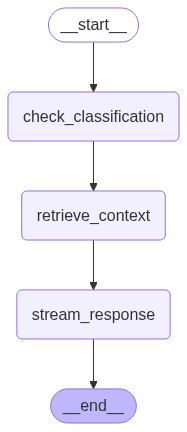

In [29]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [28]:
# L'utilisateur pose une première question
stream, classification = run_conversation("convo-abc", "Je ne reçois pas les mails de validation.")
print("Classification :", classification)
print("Réponse : ", end="")
for token in stream:
    print(token, end="", flush=True)

# L'utilisateur continue dans le même sujet
stream2, classification2 = run_conversation("convo-abc", "Et je fais quoi si ça persiste ?")
print("\n\nClassification (reprise) :", classification2)
print("Réponse : ", end="")
for token in stream2:
    print(token, end="", flush=True)


Classification : {'type': 'INCIDENT', 'severite': 'CRITIQUE'}
Réponse : 

Classification (reprise) : {'type': 'INCIDENT', 'severite': 'CRITIQUE'}
Réponse : 